In [1]:
#basic python imports
import numpy as np
import pickle
import time as tm
import qetpy as qp


#plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['figure.figsize'] = [10, 6.5]

#fft stuff
from scipy.fftpack import fft, ifft, fftfreq

#various QETpy functions
from qetpy.core.didv._uncertainties_didv import get_dPdI_with_uncertainties
from qetpy.core.didv._templates_didv import _p_delta_frequency, _p_pulse_frequency, get_didv_template, get_phonon_template
from qetpy.core.didv._templates_didv import get_simple_energy_normalization, get_energy_normalization
from qetpy.utils import make_template_twopole, make_template_threepole
from qetpy.core.didv._uncertainties_didv import get_power_noise_with_uncertainties, get_dPdI_with_uncertainties
from qetpy import Noise
from qetpy.sim import TESnoise
from qetpy.plotting import compare_noise, plot_noise_sim

#from detprocess import Template
#from detprocess import Noise

#for reading in data
from pytesdaq.io.hdf5 import H5Reader
from glob import glob
from scipy.fftpack import fft, ifft, fftfreq

from pytesdaq.io.hdf5 import H5Reader
from pytesdaq.processing import process_ivsweep, IVanalysis
from pytesdaq.processing import _iv_didv_tools_plotting as plot


rsh = 5e-3
fs = 1.25e6

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/site-packages/pytz/__init__.py:499: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/share/zoneinfo/zone.tab' mode='r' encoding='UTF-8'>
  for l in open(os.path.join(_tzinfo_dir, 'zone.tab'))
/home/mwilliams/.local/lib/python3.6/site-packages/paramiko/transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core 

Wakepy using: jeepney (dbus)


In [2]:
import h5py as h5
test_file = '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T232615_F0001.hdf5'
file = h5.File( test_file, 'r' )
print( file.keys() )
print( file['adc1'].attrs.keys())

print(file['adc1'].attrs['connection2'])
print(file['detconfig1'].attrs.keys())
print(file['detconfig1'].attrs['tes_bias'])

<KeysViewHDF5 ['adc1', 'detconfig1']>
<KeysViewHDF5 ['adc_channel_indices', 'adc_conversion_factor', 'connection2', 'data_mode', 'nb_channels', 'nb_events', 'nb_samples', 'sample_rate', 'trig_channel', 'voltage_range']>
['detector:IrPtTESBig' 'tes:C' 'controller:feb1_C']
<KeysViewHDF5 ['adc_channel_indices', 'adc_conversion_factor', 'adc_name', 'channel_list', 'channel_type', 'close_loop_norm', 'feedback_mode', 'feedback_polarity', 'feedback_resistance', 'lock_point_voltage', 'open_loop_full_norm', 'open_loop_preamp_norm', 'output_gain', 'output_offset', 'preamp_gain', 'shunt_resistance', 'signal_gen_current', 'signal_gen_frequency', 'signal_gen_onoff', 'signal_gen_phase_shift', 'signal_gen_shape', 'signal_gen_source', 'signal_gen_tes_resistance', 'signal_gen_voltage', 'signal_source', 'squid_bias', 'squid_turn_ratio', 'tes_bias']>
0.00020989012


### Reading in the data for the various files. For the big tes use 'iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T232615_F0001.hdf5' and for the small use 'iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T194128_F0001.hdf5'

In [3]:
#this is the folder or file where data is located
path =  '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T194128_F0001.hdf5' #Small TES '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T232615_F0001.hdf5'# big tes #'/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T193548_F0001.hdf5' Small TES 70uA #'/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/didv_I2_D20220914_T230343_F0001.hdf5' Big TES 250uA

#these are the channel(s) we want to analyze. For dIdVs, this should just be a single channel of data
chans = ['IrPtTESSmall']#IrPtTESBig

h5read = H5Reader()
traces_temp, metadata = h5read.read_many_events(
    filepath = path,
    nevents=-1, #this tells read_many_events to read all the events in the file
    output_format=2,
    detector_chans=chans,
    include_metadata=True, #we want the metadata to look at e.g. the device bias current
    adctoamp = True
)

In [4]:
traces = []
i = 10 #there can sometimes be data quality issues with the first few events in dIdVs
       #so we skip the first 10 events
while i < len(traces_temp):
    traces.append(traces_temp[i][0])
    i += 1

traces = np.asarray(traces)

#this line does autocuts on the traces and reduces traces to only good events
#can be commented out if it's being slow and the data is known to be high quality
traces = np.asarray(traces)[qp.autocuts_didv(np.asarray(traces))]

In [5]:
#these parameters are loaded into the dIdV to make the smallsignalparameters correct
#later, these parameters are essentially refit from understanding the true current
#through the TES. However, we need to run the dIdV fit once first to get the dIdV
#offset fit.
rp = 0.003 #ohms, parasitic resistance
r0 = 0.182 #ohms, TES resistance at bias point
rsh = 5e-3 #ohms, shunt resistance, the standard Pyle group value
fs = int(1.25e6) #Hz, sampling frequency
sgfreq = float(metadata[0]['detector_config'][chans[0]]['signal_gen_frequency']) #the signal generator frequency
                                                                                 #read in directly from metadata
sgamp = float(metadata[0]['detector_config'][chans[0]]['signal_gen_current']) #the signal generator amplitude
                                                                              #read in directly from metadata


didvfit = qp.DIDV(
    traces,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    r0=r0, # the expected r0 should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    rp=rp, # the expected rp should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    dt0=-1e-6, # a good estimate of the time shift value will likely speed up the fit/improve accuracy
    add180phase=False, # if the fits aren't working, set this to True to see if the square wave is off by half a period
)

### Do the two and three pole fits first with some guesses and no offsets

In [6]:
didvfit.dofit(2)
print("Done with Two Pole Fit")
didvfit.dofit(3)
print("Done with Three Pole Fit")

Done with Two Pole Fit
Done with Three Pole Fit


In [7]:
result2 = didvfit.fitresult(2) 
result3 = didvfit.fitresult(3) 

### First look at the fit results that we will be tweaking 

In [8]:
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result3['params']['tau1'])) + ' s')
print("Tau2: " + str(result3['params']['tau2']) + ' s')
print("Tau3: " + str(result3['params']['tau3']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result3['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result3['falltimes'][1]) + ' s')
print("Tau_third: " + str(result3['falltimes'][2]) + ' s')

Fit time constants, NOT dIdV Poles: 
Tau1: 8.794408524286518e-06 s
Tau2: 1.2791013859213453e-06 s
Tau3: 0.0003004915483259753 s
 
True dIdV Poles: 
Tau_plus: 1.5899461530947237e-06 s
Tau_minus: 2.554265676391486e-05 s
Tau_third: 0.000301585437193594 s


### The next few cells are to run the IV sweep on the selected channel. It then calculates the current offset. Do not run unless you need to!!

In [9]:
IV_dIdV_sweep_folder = '/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121' #small #'/sdata1/runs/run20/raw/iv_didv_I2_D20220914_T210929/' #Big TES
chans = ['IrPtTESSmall']
channel_num = 0

In [10]:
# create an object of the H5Reader class 
h5read = H5Reader() 

# get the start time so we know the total time 
start_time = tm.time()

# get the dataframe for the processed raw data
df = []
df = process_ivsweep(
    ivfilepath=IV_dIdV_sweep_folder,
    chans=chans,
    lgcverbose=True, # Switch to True to know which file its on
    lgcsave=False,
)
# get the end time 
end_time = tm.time()

print(f'IV sweep took {(end_time - start_time)/60: .3f} min to process')

#need to flip the QET bias for all the Pyle lab data
df.qetbias*= -1 

#convert the dataframe into a IV object that we can work with
IVobj = IVanalysis(
    df, 
    rshunt = 5e-3,
    nnorm=5, # number of points in normal region
    nsc=5, # number of points in superconducting region
    lgcremove_badseries = False
)

IVobj.rshunt_err = 0.1e-3


Processing dumps in: /sdata1/runs/run20/raw/iv_didv_I2_D20220914_T180121/didv_I2_D20220914_T180303_F0001.hdf5



OSError: Unable to get traces or detector settings from hdf5 data!

In [ ]:
#make a few plots to ensure all is well
IVobj.analyze_sweep(lgcplot = True)

In [ ]:
#read in 2 events to get the metadata
didvfilepath = sorted(glob(IV_dIdV_sweep_folder + '/didv_*'))[0]
traces_temp, metadata = h5read.read_many_events(filepath = didvfilepath,
    nevents=2,
    output_format=2,
    detector_chans=chans,
    include_metadata=True,
    adctoamp = True
)

#generate the offset dictionary
offset_dict = IVobj.get_offsets_dict(metadata, chans[0])

print(offset_dict)

{'i0_off': 5.845555082229474e-06, 'i0_off_err': 3.616277043376477e-10, 'ibias_off': -1.0275022938861674e-07, 'ibias_off_err': 6.917024398816581e-10, 'i0_changable_offset': -7.3260075e-08, 'rp': 0.004510713735657516, 'IVobj': <pytesdaq.processing._iv_didv_tools.IVanalysis object at 0x7efbc4a35e80>}


In [ ]:
#save the offset dictionary
#rq_files_path = '/sdata1/runs/run20/processed/'
#save_dict_name = 'offsets_' + str(chans[channel_num]) + "_"
#print("Save as: " + save_dict_name)

#with open(rq_files_path + save_dict_name, 'wb') as handle:
#    pickle.dump(offset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### The next cell reads in a previously created offset dictionary and then proceeds to recalculate the didv and fit the data with the offsets in mind 

In [10]:
save_dict_name = 'offsets_IrPtTESSmall_'
rq_files_path = '/sdata1/runs/run20/processed/'

with open(rq_files_path + save_dict_name, 'rb') as handle:
    offsets_dict = pickle.load(handle)

print(offsets_dict)

{'i0_off': 5.845555082229474e-06, 'i0_off_err': 3.616277043376477e-10, 'ibias_off': -1.0275022938861674e-07, 'ibias_off_err': 6.917024398816581e-10, 'i0_changable_offset': -7.3260075e-08, 'rp': 0.004510713735657516, 'IVobj': <pytesdaq.processing._iv_didv_tools.IVanalysis object at 0x7f4ddcc52080>}


In [11]:
channel_name = 'IrPtTESSmall'

#gets information from the metadata loaded in when we loaded in traces to understand the offsets on the dIdV
output_offset = float(metadata[0]['detector_config'][channel_name]['output_offset'])
closed_loop_norm = float(metadata[0]['detector_config'][channel_name]['close_loop_norm'])
ibias_metadata = float(metadata[0]['detector_config'][channel_name]['tes_bias'])

### refit things but this time with the offsets

In [12]:
didvfit.dofit_with_true_current(offsets_dict, output_offset, closed_loop_norm, ibias_metadata)
result = didvfit.fitresult(3) #this is the actual object we inspect when we want to know information
                                         #about the dIdV fit

### Let's look at the different didv traces 

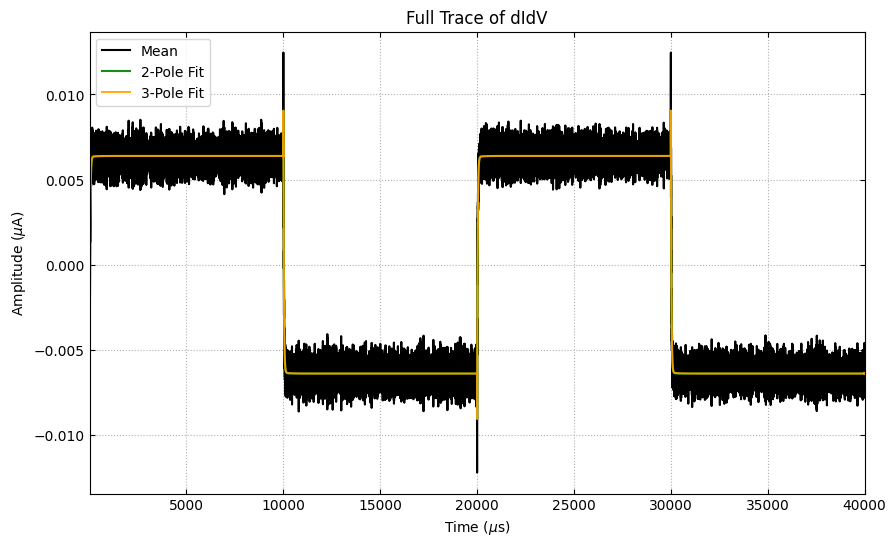

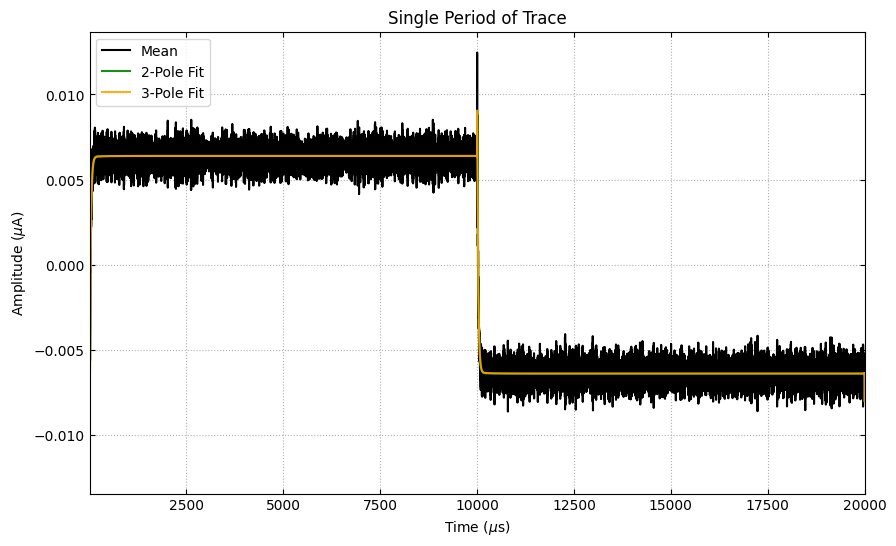

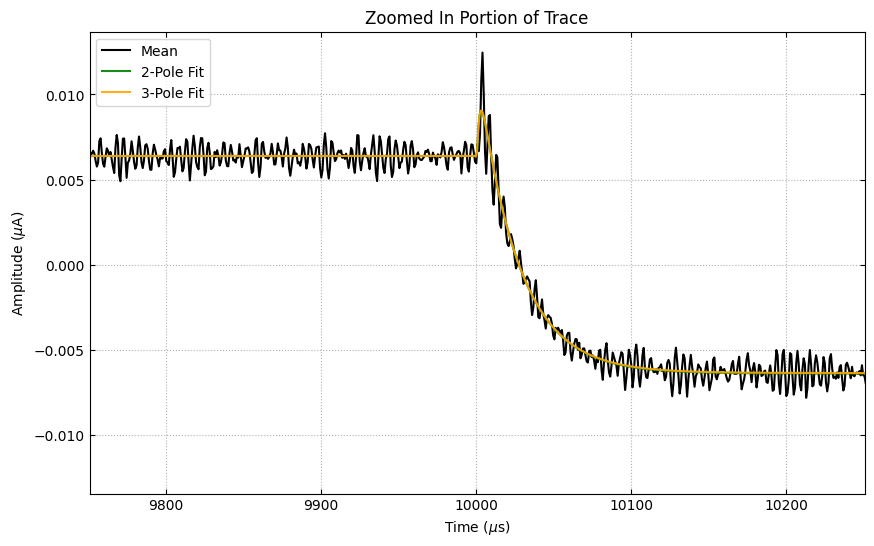

In [13]:
didvfit.plot_full_trace()
didvfit.plot_single_period_of_trace()
didvfit.plot_zoomed_in_trace(zoomfactor=0.025)

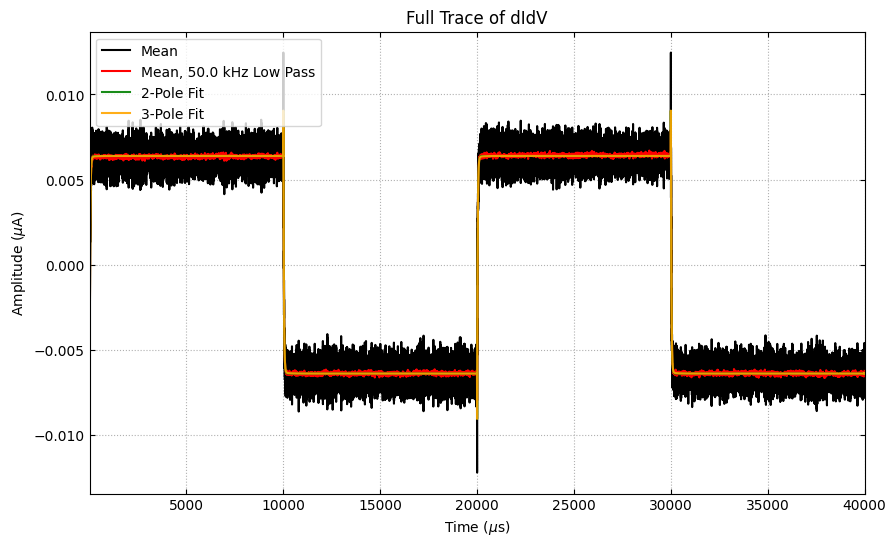

/home/mwilliams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/mwilliams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


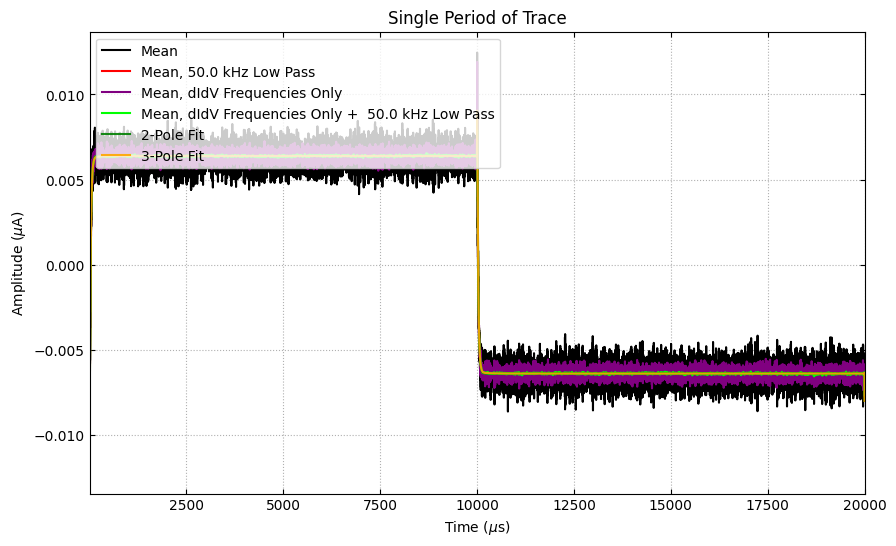

/home/mwilliams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/mwilliams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


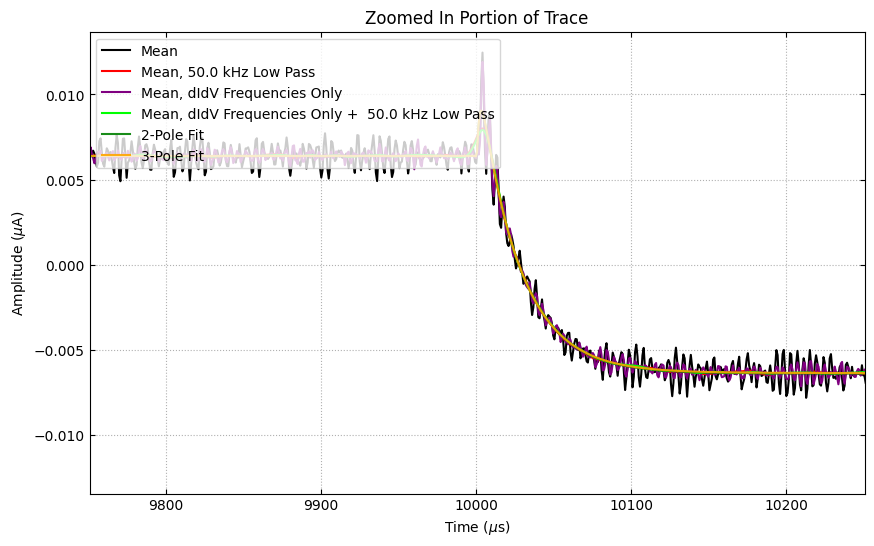

In [14]:
#didvfit.plot_full_trace(didv_freq_filt = False, lp_cutoff = 50e3,plotmean=False)
didvfit.plot_full_trace(didv_freq_filt = False, lp_cutoff = 50e3)
didvfit.plot_single_period_of_trace(didv_freq_filt = True, lp_cutoff = 50e3)
#didvfit.plot_zoomed_in_trace(zoomfactor=0.025, didv_freq_filt = False,plotmean=False, lp_cutoff = 50e3)
didvfit.plot_zoomed_in_trace(zoomfactor=0.025, didv_freq_filt = True, lp_cutoff = 50e3)

### These flipped traces are a way to check if the measurement is good. If the square wave was driven at too high an amplitude, the fit can be off. This is because the voltage is too high and can cause different response and tes dynamics than expected 

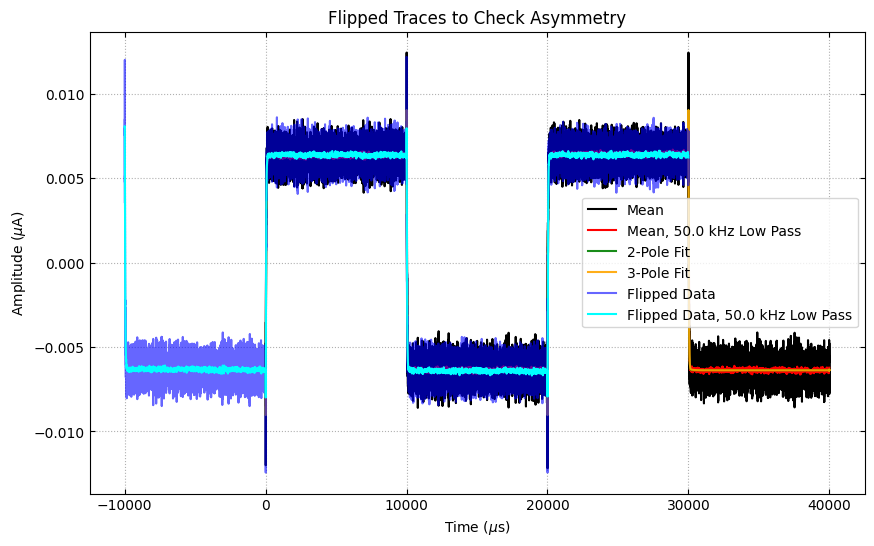

/home/mwilliams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/mwilliams/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


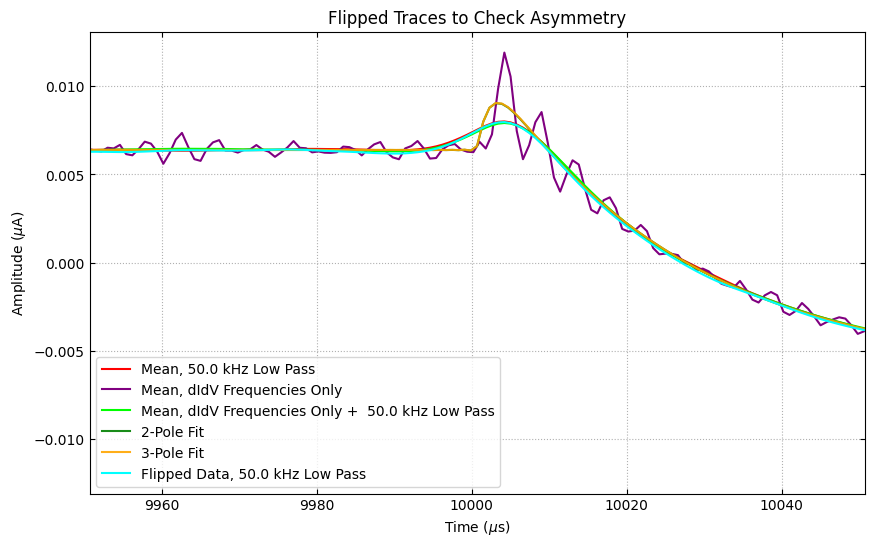

In [15]:
didvfit.plot_didv_flipped(lp_cutoff = 50e3)
#didvfit.plot_didv_flipped(lp_cutoff = 50e3,poles=False, meanonly = True, zoomfactor = 0.025,didv_freq_filt=False,plotmean=False)
didvfit.plot_didv_flipped(lp_cutoff = 50e3,poles='all', zoomfactor = 0.005,plotmean=False,flippedmean=False,didv_freq_filt=True)

### Actual didv fits

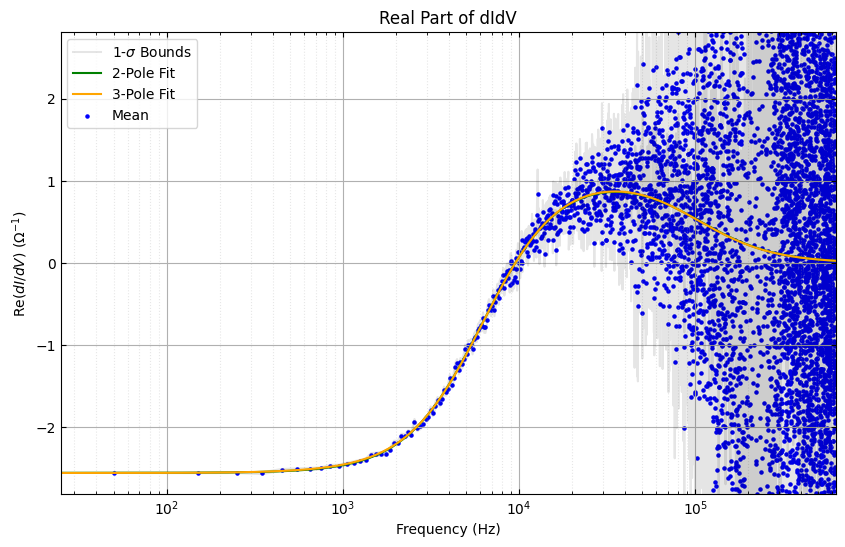

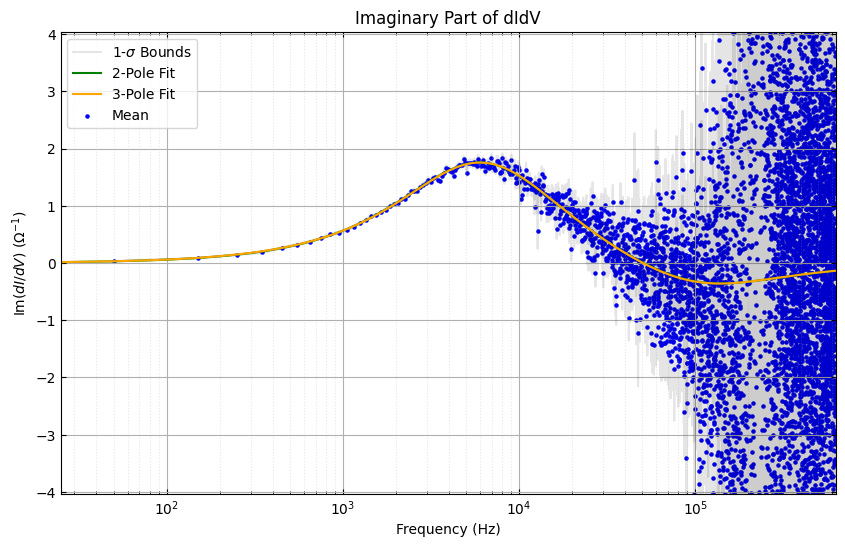

In [16]:
didvfit.plot_re_im_didv()

In [17]:
print("Fit parameters: ")
print(result['params'])
print(" ")
print("Fit covariance matrix: ")
print(result['cov'])

Fit parameters: 
{'A': 1.4203016072794106, 'B': -1.8135874213710859, 'C': -0.00091832045158835, 'tau1': -8.794408524286518e-06, 'tau2': 1.2791013859213453e-06, 'tau3': 0.0003004915483259753, 'dt': -3.2493822184032995e-07}
 
Fit covariance matrix: 
[[ 3.28709822e-04 -3.27827364e-04  5.75317285e-07  9.92047936e-10
   4.99991790e-10  1.17600882e-07 -1.96192396e-10]
 [-3.27827368e-04  3.27296805e-04 -3.92043712e-07 -9.87377544e-10
  -5.05483938e-10 -4.90202619e-08  1.98199281e-10]
 [ 5.75315481e-07 -3.92041906e-07  1.05268276e-07  2.57619151e-12
  -2.70025490e-12  3.38567490e-08  9.38648675e-13]
 [ 9.92047916e-10 -9.87377514e-10  2.57619692e-12  4.45994319e-15
   3.60039804e-16  5.32981238e-13  7.84448864e-16]
 [ 4.99991858e-10 -5.05484000e-10 -2.70025204e-12  3.60040037e-16
   2.06432145e-15 -1.03731281e-12 -1.43283965e-15]
 [ 1.17600213e-07 -4.90195933e-08  3.38567485e-08  5.32979226e-13
  -1.03731385e-12  2.54073488e-08  3.47820250e-13]
 [-1.96192421e-10  1.98199304e-10  9.38647554e-13 

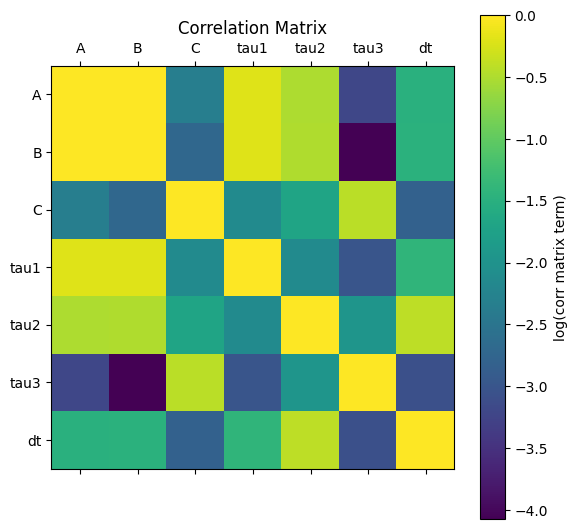

In [18]:
cov_matrix = result['cov']

#construct the correlation matrix
cor_matrix = np.zeros([7,7])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = np.abs(cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j])))
        j += 1
    i += 1
    
#plot the correlation matrix
labels = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']
ticks = np.arange(0, 7, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

### It's super important to give the code good guesses and fit parameters. It takes some playing around to get a good fit sometimes but here are the ones for the IrPT

In [19]:
bounds_right = [np.asarray([0.5, -5, -5e-3, -20e-6, 0.1e-6, 0.1e-4, -1e-9]), #small   ## small tes
                np.asarray([1.5, -1, -1e-5, -1e-6, 4e-6, 9e-4, 9e-10])] #big
bounds_right = np.asarray(bounds_right)
guess_params = np.asarray([1, -2, -9e-4, -9e-6, 1e-6, 3e-4, 1e-10]) 

#bounds_right = [np.asarray([0.1,   -4,   -3,   -30e-6,   0.5e-6, 0.5e-5, -1e-9]), #small      # big tes
#                np.asarray([1.1,   -0.5,   3 ,   -5e-6,    4e-6,   3e-5,   9e-10])] #big
#bounds_right = np.asarray(bounds_right)
#guess_params = np.asarray([0.3, -0.7, -1.01, -20e-6, 2e-6, 1e-5, 1e-10])

#refit using these bounds
didvfit.dofit_with_true_current(offsets_dict, output_offset, closed_loop_norm, ibias_metadata,
                                guess=guess_params, bounds=bounds_right)
result = didvfit.fitresult(3)

In [20]:
print("Fit parameters: ")
print(result['params'])
print(" ")

Fit parameters: 
{'A': 1.4124716048744592, 'B': -1.8056528740791784, 'C': -0.000874389797121661, 'tau1': -8.632404302467954e-06, 'tau2': 1.1306180499886996e-06, 'tau3': 0.0003173971964334068, 'dt': -9.999999999993075e-10}
 


In [21]:
result

{'lgcfix': None,
 'params': {'A': 1.4124716048744592,
  'B': -1.8056528740791784,
  'C': -0.000874389797121661,
  'tau1': -8.632404302467954e-06,
  'tau2': 1.1306180499886996e-06,
  'tau3': 0.0003173971964334068,
  'dt': -9.999999999993075e-10},
 'cov': array([[ 3.25893964e-04, -3.24921080e-04,  6.17382432e-07,
          9.79382114e-10,  4.99135759e-10,  1.56225489e-07,
         -1.92030425e-10],
        [-3.24921072e-04,  3.24276928e-04, -4.46056585e-07,
         -9.74694232e-10, -5.03883975e-10, -8.46605973e-08,
          1.93645965e-10],
        [ 6.17386599e-07, -4.46060755e-07,  9.92363160e-08,
          2.56973515e-12, -2.32174425e-12,  3.52559719e-08,
          7.43508928e-13],
        [ 9.79382160e-10, -9.74694303e-10,  2.56972272e-12,
          4.32717603e-15,  4.14752570e-16,  6.39469050e-13,
          6.37481305e-16],
        [ 4.99135603e-10, -5.03883832e-10, -2.32175093e-12,
          4.14752032e-16,  2.01237387e-15, -1.00889068e-12,
         -1.30647668e-15],
        [ 1.

In [22]:
result2

{'lgcfix': None,
 'params': {'A': 1.4268726320238765,
  'B': -1.8187543998194204,
  'tau1': -8.769816044072375e-06,
  'tau2': 1.2638026225692096e-06,
  'dt': -3.2113718047682446e-07},
 'cov': array([[ 3.33059261e-04, -3.32879650e-04,  9.95294425e-10,
          5.19350595e-10, -2.02201684e-10],
        [-3.32879649e-04,  3.32726498e-04, -9.94152293e-10,
         -5.19633833e-10,  2.02387597e-10],
        [ 9.95294429e-10, -9.94152298e-10,  4.42941320e-15,
          4.29861478e-16,  7.55399023e-16],
        [ 5.19350591e-10, -5.19633829e-10,  4.29861461e-16,
          1.99286670e-15, -1.40293904e-15],
        [-2.02201682e-10,  2.02387595e-10,  7.55399031e-16,
         -1.40293904e-15,  2.25266142e-15]]),
 'errors': {'A': 0.01824991126412101,
  'B': 0.018240792132185064,
  'tau1': 6.655383687181328e-08,
  'tau2': 4.4641535580873044e-08,
  'dt': 4.746221042343426e-08},
 'smallsignalparams': {'rsh': 0.005,
  'rp': 0.003,
  'r0': 0.182,
  'beta': 6.796003472658662,
  'l': 8.347437319886739,

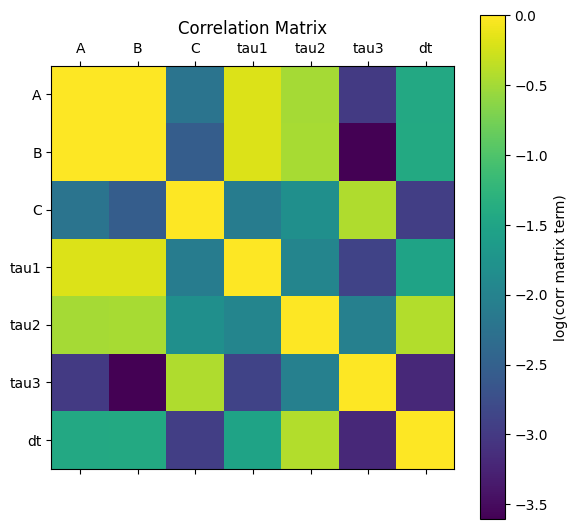

In [23]:
cov_matrix = result['cov']

#construct the correlation matrix
cor_matrix = np.zeros([7,7])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = np.abs(cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j])))
        j += 1
    i += 1
    
#plot the correlation matrix
labels = ['A', 'B', 'C', 'tau1', 'tau2', 'tau3', 'dt']
ticks = np.arange(0, 7, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

### These are the two and three pole time constants that come from this fits. The ones to look at are the three pole time constants

In [24]:
result2 = didvfit.fitresult(2)
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result2['params']['tau1'])) + ' s')
print("Tau2: " + str(result2['params']['tau2']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result2['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result2['falltimes'][1]) + ' s')


Fit time constants, NOT dIdV Poles: 
Tau1: 8.769816044072375e-06 s
Tau2: 1.2638026225692096e-06 s
 
True dIdV Poles: 
Tau_plus: 1.5663647376905479e-06 s
Tau_minus: 2.576362610876941e-05 s


In [25]:
print("Fit time constants, NOT dIdV Poles: ")
print("Tau1: " + str(np.abs(result['params']['tau1'])) + ' s')
print("Tau2: " + str(result['params']['tau2']) + ' s')
print("Tau3: " + str(result['params']['tau3']) + ' s')
print(" ")

print("True dIdV Poles: ")
print("Tau_plus: " + str(result['falltimes'][0]) + ' s')
print("Tau_minus: " + str(result['falltimes'][1]) + ' s')
print("Tau_third: " + str(result['falltimes'][2]) + ' s')

Fit time constants, NOT dIdV Poles: 
Tau1: 8.632404302467954e-06 s
Tau2: 1.1306180499886996e-06 s
Tau3: 0.0003173971964334068 s
 
True dIdV Poles: 
Tau_plus: 1.3707371526575878e-06 s
Tau_minus: 2.557170912797005e-05 s
Tau_third: 0.00031848580346684034 s


In [26]:
print("Biasparams dict: ")
print(result['biasparams'])
print(" ")
print("i0: " + str(result['biasparams']['i0']) + " +/- " + str(result['biasparams']['i0_err']) + " amps")
print("r0: " + str(result['biasparams']['r0']) + " +/- " + str(result['biasparams']['r0_err']) + " ohms")
print("v0: " + str(result['biasparams']['v0']) + " +/- " + str(result['biasparams']['v0_err']) + " volts")
print("p0: " + str(result['biasparams']['p0']) + " +/- " + str(result['biasparams']['p0_err']) + " watts")
print(" ")
print("Bias power: " + str(result['biasparams']['p0'] * 1e15) + " fW")

Biasparams dict: 
{'i0': 7.620926645999903e-07, 'i0_err': 3.6190015112169347e-10, 'v0': 3.186625313707134e-07, 'v0_err': 4.230888882537907e-12, 'r0': 0.4181414494233113, 'r0_err': 0.0001986432813926575, 'p0': 2.4285037764048495e-13, 'p0_err': 1.1536908375977564e-16}
 
i0: 7.620926645999903e-07 +/- 3.6190015112169347e-10 amps
r0: 0.4181414494233113 +/- 0.0001986432813926575 ohms
v0: 3.186625313707134e-07 +/- 4.230888882537907e-12 volts
p0: 2.4285037764048495e-13 +/- 1.1536908375977564e-16 watts
 
Bias power: 242.85037764048496 fW


In [27]:
print("smallsignalparameters dict:")
print(result['smallsignalparams'])
print(" ")
print(" ")

print("ssp_light dict: ")
print(result['ssp_light'])
print(" ")
print(" ")

print("Light SSP calculated values: ")
print(result['ssp_light']['vals'])
print(" ")
print("Light SSP calculated covariance matrix: ")
print(result['ssp_light']['cov'])
print(" ")
print("Light SSP uncertainties: ")
print(result['ssp_light']['sigmas'])

smallsignalparameters dict:
{'rsh': 0.005, 'rp': 0.004510713735657516, 'r0': 0.4181414494233113, 'beta': 2.3552303725778088, 'l': -116.874772088324, 'L': 1.59696589156757e-06, 'tau0': -0.0010175426897276775, 'gratio': -0.10306849805207165, 'tau3': 0.0003173971964334068, 'dt': -9.999999999993075e-10}
 
 
ssp_light dict: 
{'vals': {'beta': 2.3552303725778088, 'l': -116.874772088324, 'L': 1.59696589156757e-06, 'tau0': -0.0010175426897276775, 'gratio': -0.10306849805207165}, 'cov': array([[ 1.86647196e-03+0.j, -3.50911469e-02+0.j,  2.56725746e-09+0.j,
        -2.68272744e-08+0.j,  1.43358068e-04+0.j],
       [-3.50909981e-02+0.j,  2.17994219e+01+0.j, -1.12261329e-07+0.j,
         1.84924949e-04+0.j,  1.68432445e-01+0.j],
       [ 2.56725694e-09+0.j, -1.12261525e-07+0.j,  6.02563397e-15+0.j,
        -7.69503382e-13+0.j, -4.02439964e-10+0.j],
       [-2.68259772e-08+0.j,  1.84924927e-04+0.j, -7.69501598e-13+0.j,
         1.62836056e-09+0.j,  1.48683479e-06+0.j],
       [ 1.43359372e-04+0.j, 

In [28]:
extracted_rp

NameError: name 'extracted_rp' is not defined

In [29]:
extracted_rl

NameError: name 'extracted_rl' is not defined

In [30]:
#To calculate it more simply
print('V_b = ',extracted_rsh*209e-6)

NameError: name 'extracted_rsh' is not defined

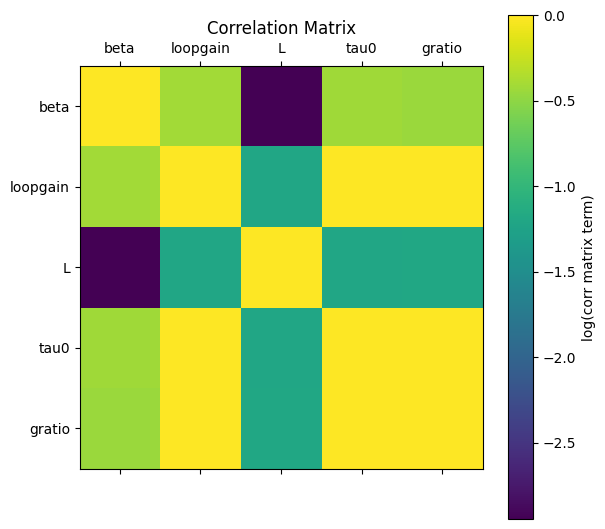

In [31]:
cov_matrix = np.abs(result['ssp_light']['cov'])
vals_vector = result['ssp_light']['vals']
cor_matrix = np.zeros([5,5])

i = 0
while i < len(cov_matrix):
    j = 0
    while j < len(cov_matrix[i]):
        cor_matrix[i][j] = cov_matrix[i][j]/(np.sqrt(cov_matrix[i][i]) * np.sqrt(cov_matrix[j][j]))
        j += 1
    i += 1

labels = ['beta', 'loopgain', 'L', 'tau0', 'gratio']
ticks = np.arange(0, 5, 1)
plt.matshow(np.log(cor_matrix))
plt.xticks(ticks=ticks, labels=labels)
plt.yticks(ticks=ticks, labels=labels)
plt.colorbar(label = "log(corr matrix term)")
plt.title("Correlation Matrix")
plt.show()

### This is code to get a noise model out if you want it. It allows you to make plots of the power noise etc. No need to run unless you want to!

In [4]:
noise_chans = ['IrPtTESSmall','IrPtTESBig']
traces_temp, metadata = h5read.read_many_events(filepath = '/sdata1/runs/run20/raw/continuous_I2_D20220918_T165211',
    nevents=-1,
    output_format=2,
    detector_chans=noise_chans,
    include_metadata=True,
    adctoamp = True
)


In [5]:
Noise?

Init signature: Noise(traces, fs, channames, tracegain=1.0, name=None, time=None)
Docstring:     
This class allows the user to calculate the power spectral densities of signals 
from detectors, study correlations, and decouple the intrinsic noise from cross 
channel correlated noise. 

Attributes
----------
traces : ndarray
    Array of the traces to use in the noise analysis. Should be shape 
    (# of traces, # of channels, # of bins)
fs : float
    The digitization rate of the data in Hz.
channames : list
    A list of strings that name each of the channels.
time : ndarray
    The time values for each bin in each trace.
name : str
    The file name of the data, this will be used when saving the file.
tracegain : float
    The factor that traces should be divided by to convert the units to Amps. If rawtraces
    already has units of Amps, then this should be set to 1.0
freqs : ndarray
    The frequencies that correspond to each value in the spectral densities
psd : ndarray
    The p

In [6]:
IrPt_noise = Noise(traces=traces_temp,
                   fs=1.25e6, 
                   channames=noise_chans,
                   name='IrPtTES_noise')

In [7]:
IrPt_noise.calculate_psd()
IrPt_noise.calculate_corrcoeff()
IrPt_noise.calculate_csd()
IrPt_noise.calculate_uncorr_noise()

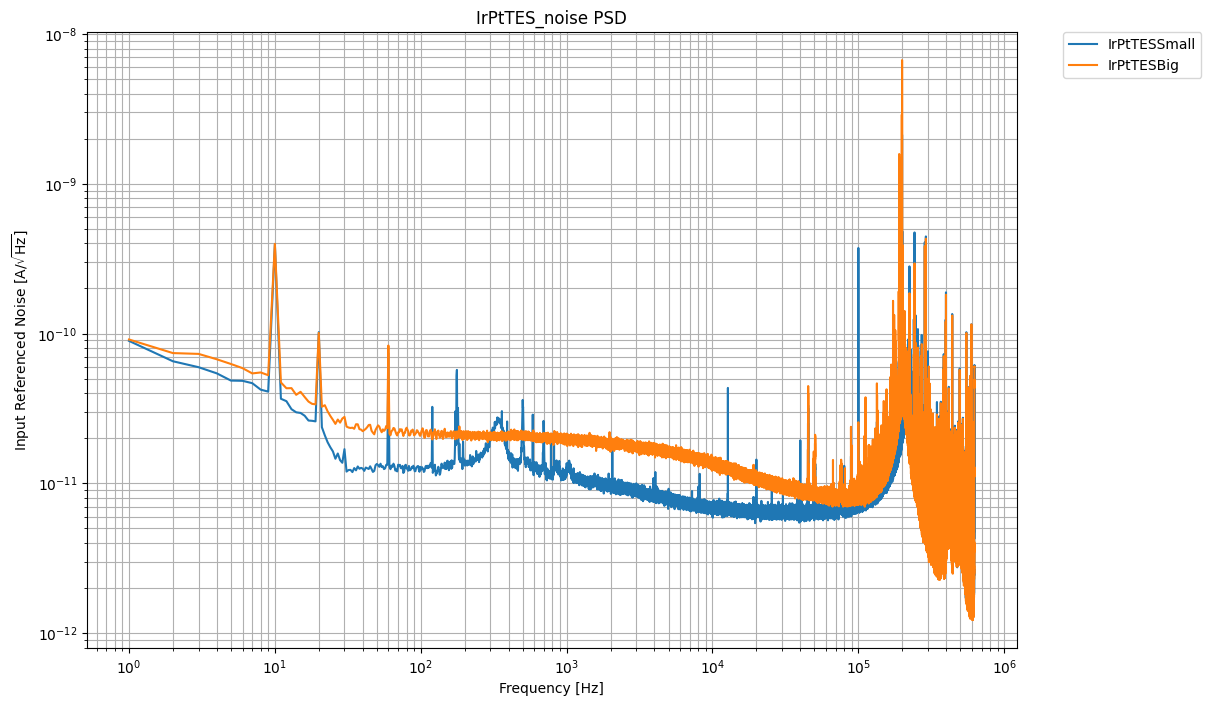

In [8]:
IrPt_noise.plot_psd(lgcoverlay=True)

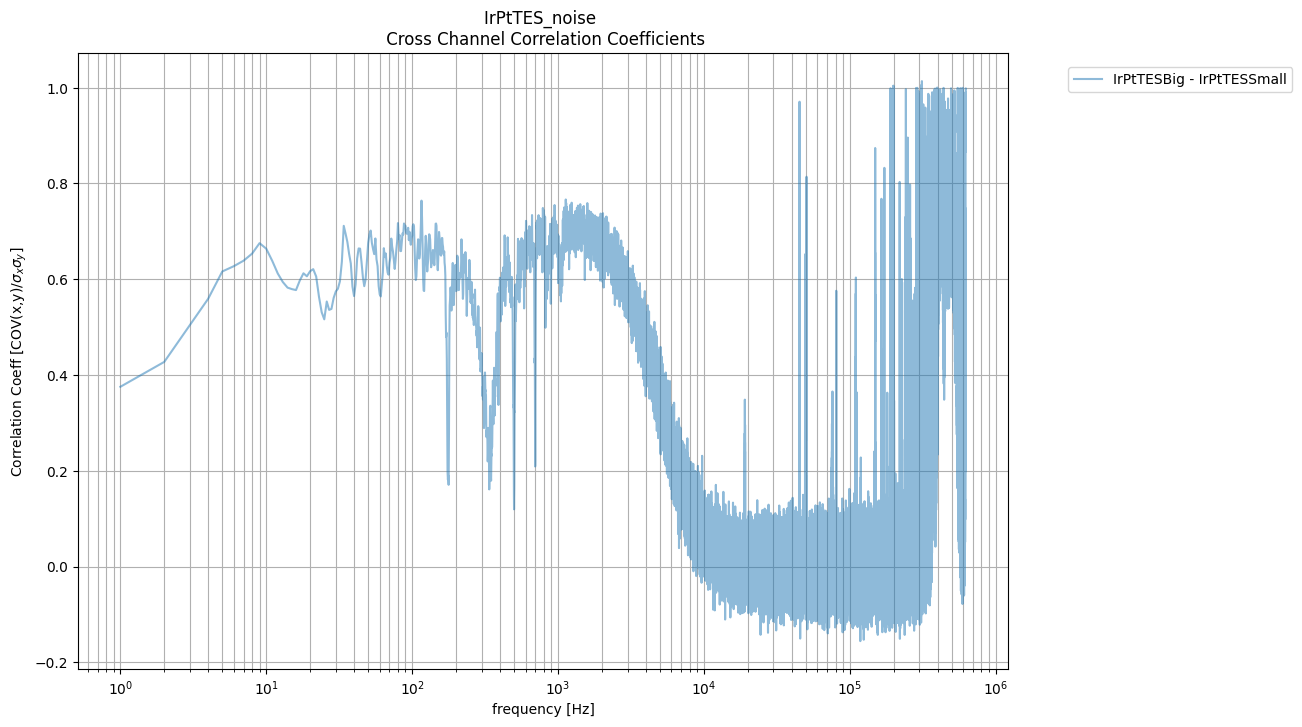

In [9]:
IrPt_noise.plot_corrcoeff(lgcsave=False, lgcsmooth=True, nwindow=9 )

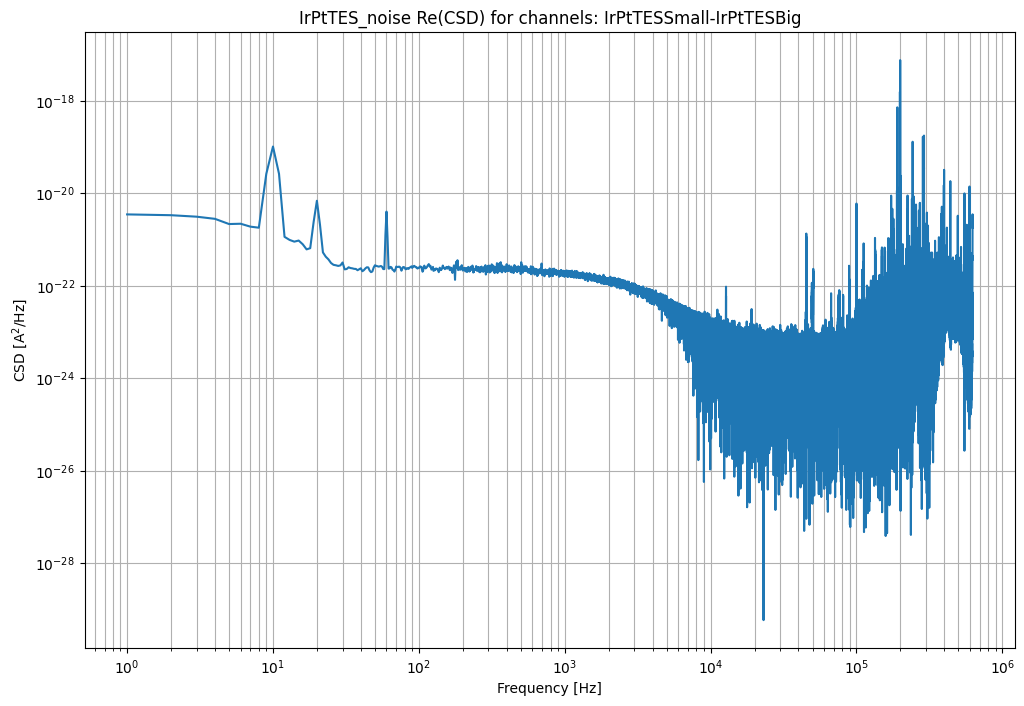

In [10]:
IrPt_noise.plot_csd()

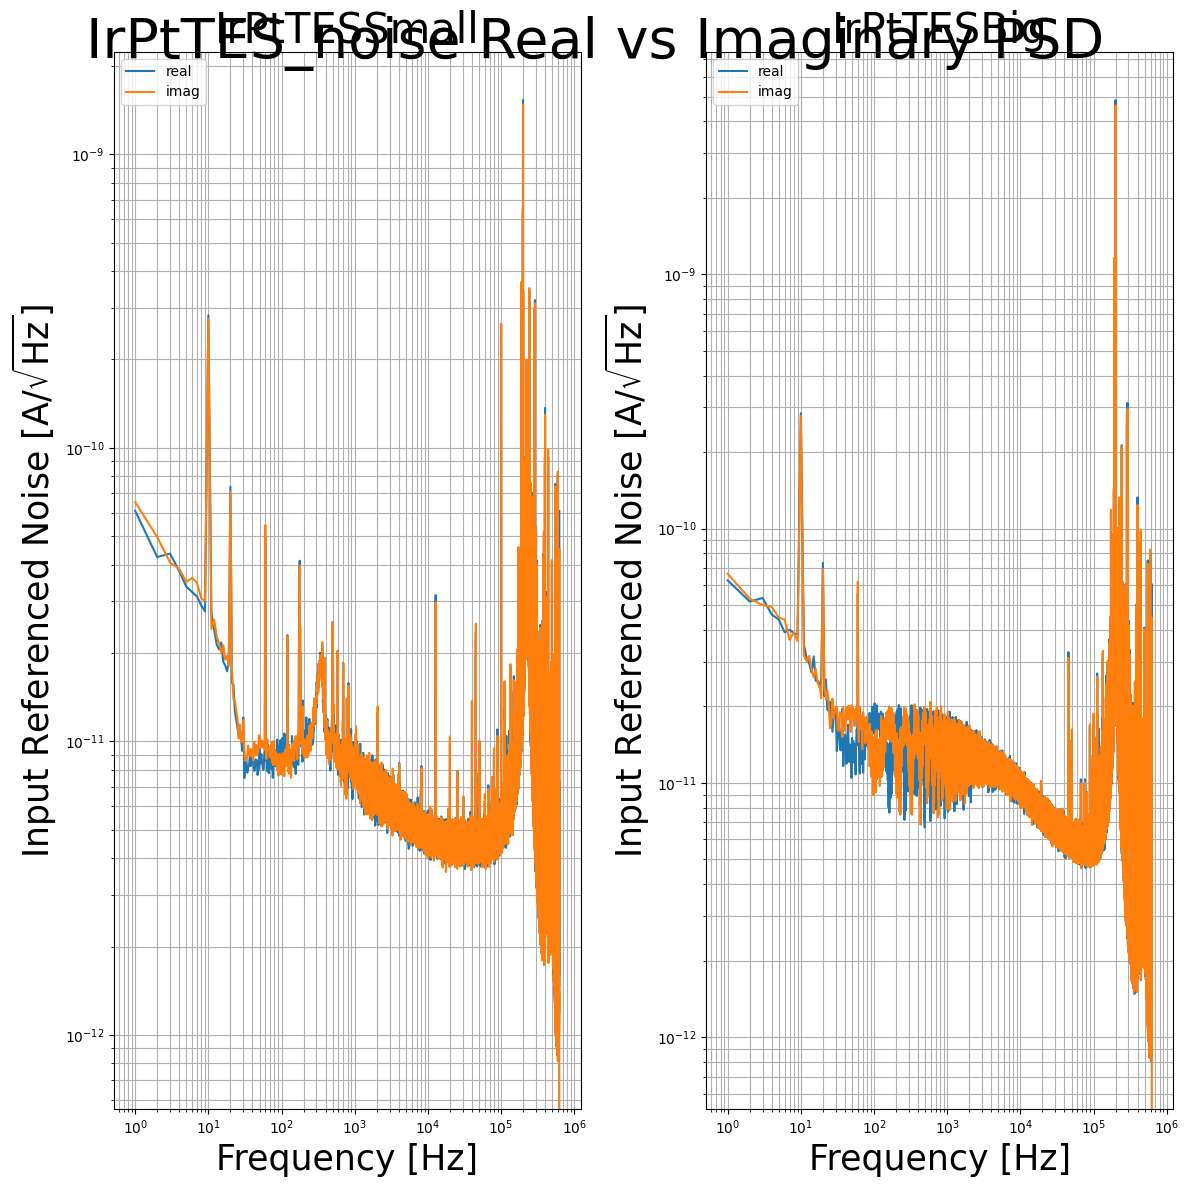

In [11]:
IrPt_noise.plot_reim_psd()

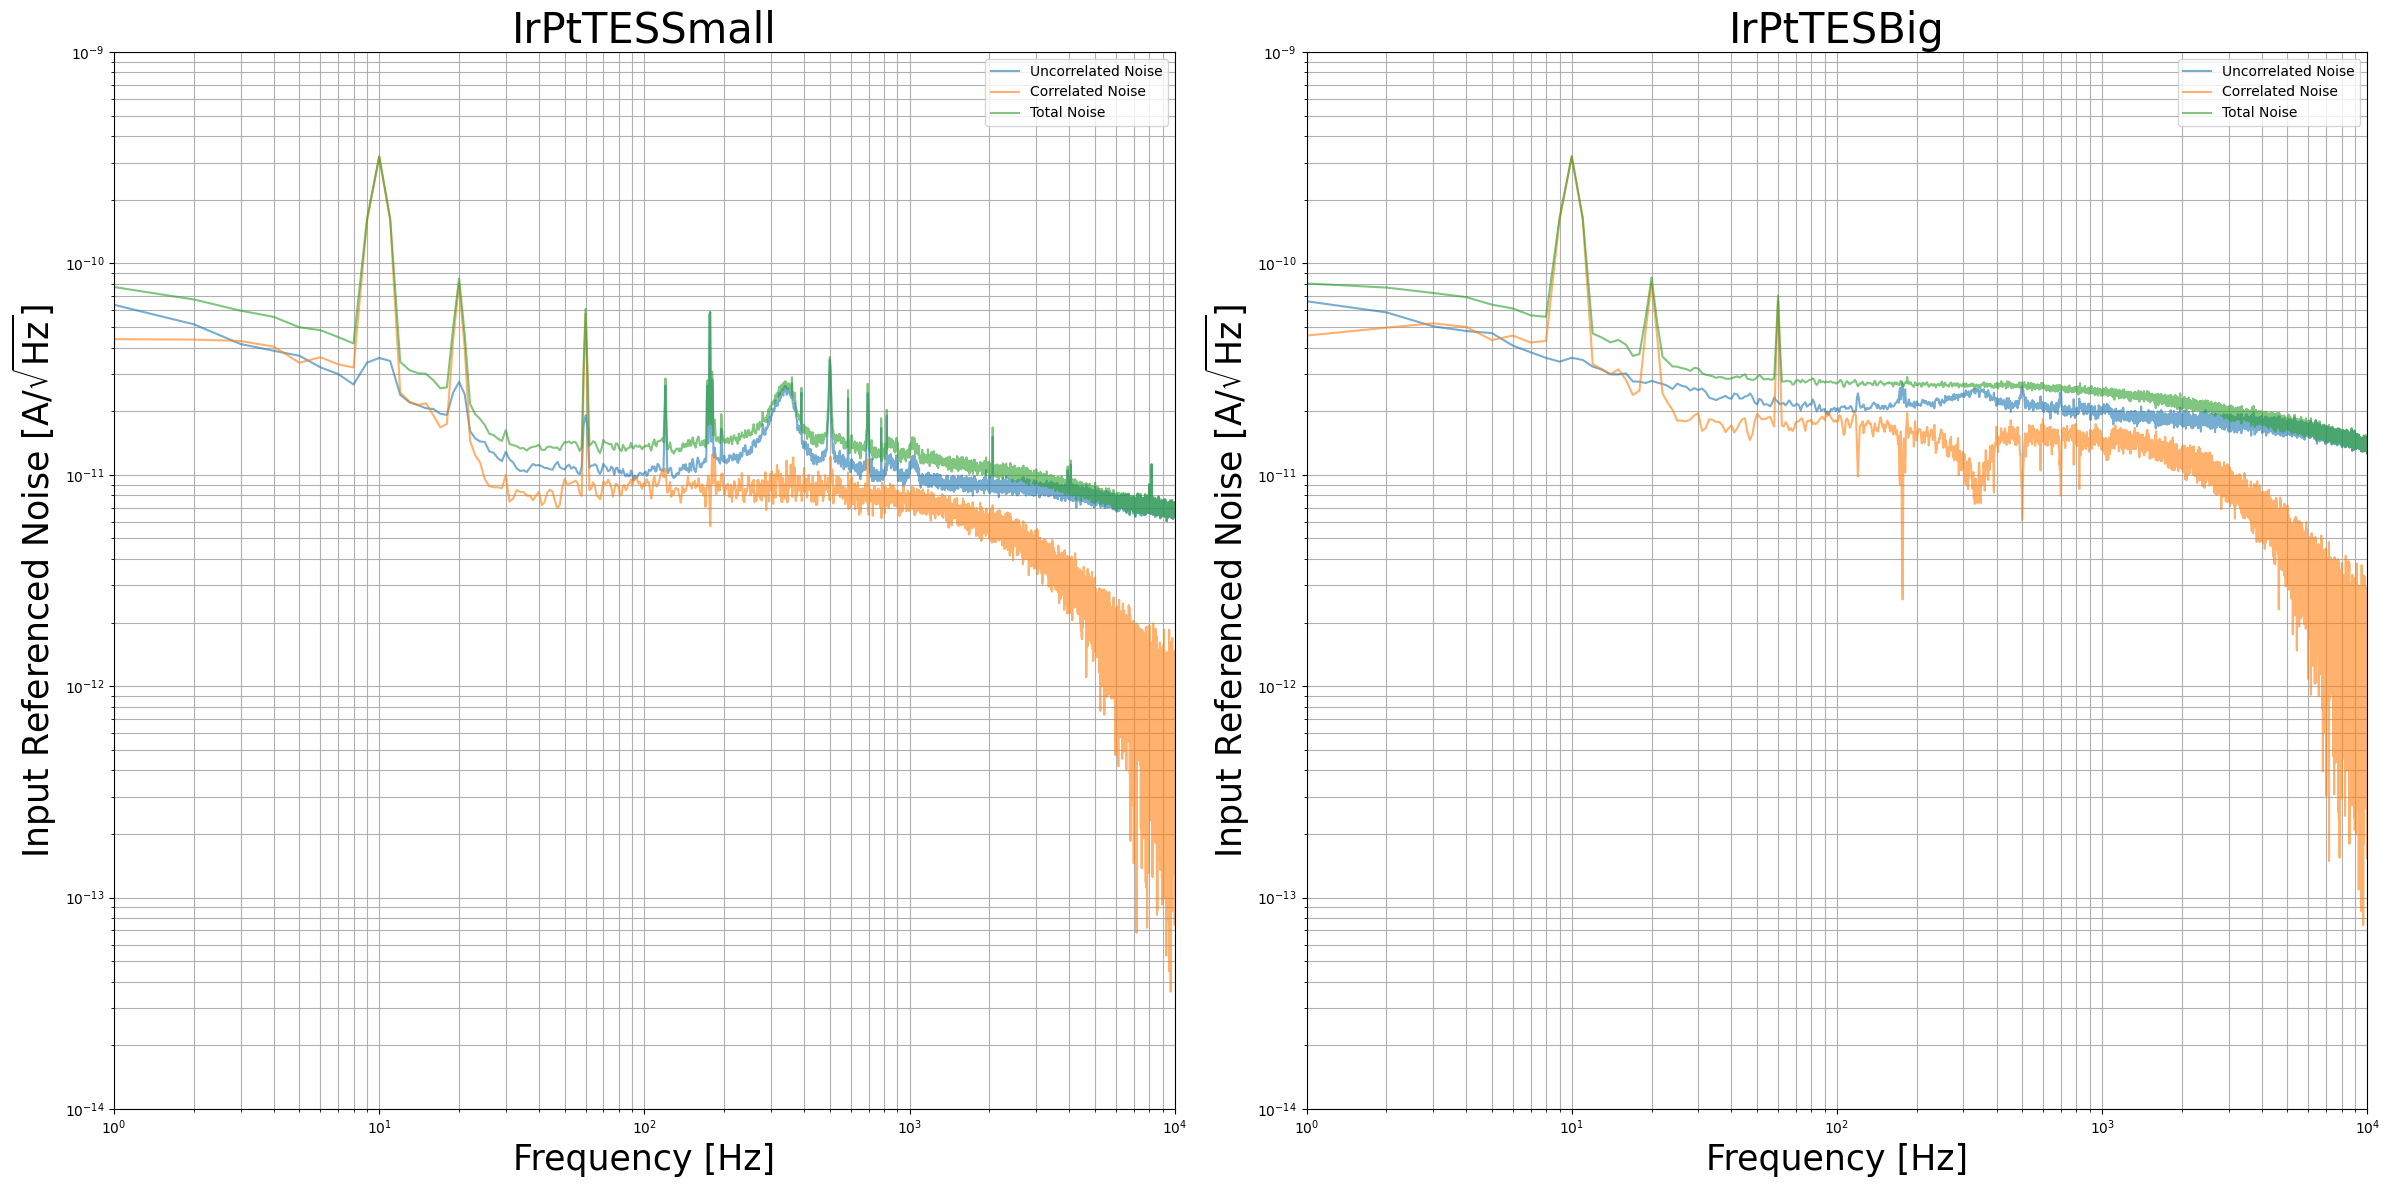

In [12]:
IrPt_noise.plot_decorrelatednoise(lgccorrelated=True,lgcsum = True, lgcsave=False,lgcoverlay=False,lgcdata=False)

In [42]:
#saveName = '/home/mwilliams/QETpy/demos/didv' + IrPt_noise.name.replace(" ", "_") + '.pkl'
#IrPt_noise.save('/home/mwilliams/QETpy/demos/didv')

In [43]:
#with open('IrPtTES_noise.pkl','rb') as savefile:
#    IrPt_file = pickle.load(savefile)

In [44]:
#print(IrPt_noise.__dict__)
print(IrPt_noise.corrnoise[1][0:])
print(IrPt_noise.corrnoise[0][0:])
print(IrPt_noise.corrnoise[-1][0:])

[4.29845835e-22 2.07644933e-21 2.46652009e-21 ... 2.92942380e-21
 3.06683305e-21 1.77925205e-21]
[4.07784162e-22 1.92208439e-21 1.90288176e-21 ... 3.01658839e-21
 3.14674066e-21 1.81915518e-21]
[4.29845835e-22 2.07644933e-21 2.46652009e-21 ... 2.92942380e-21
 3.06683305e-21 1.77925205e-21]


In [49]:
#noise_path = '/sdata1/runs/run26/RQFiles/noise_continuous_I2_D20230321_T002644'

#with open(noise_path, 'rb') as handle:
#    noise_dict = pickle.load(handle)
uncorrelated_noise_current = IrPt_noise.uncorrnoise[1][1:]
correlated_noise_current = IrPt_noise.corrnoise[1][1:]
freqs = IrPt_noise.freqs[1:]
print("Loaded noise")

Loaded noise


Uncorrelated noise (only in TES):


/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1164: Comp

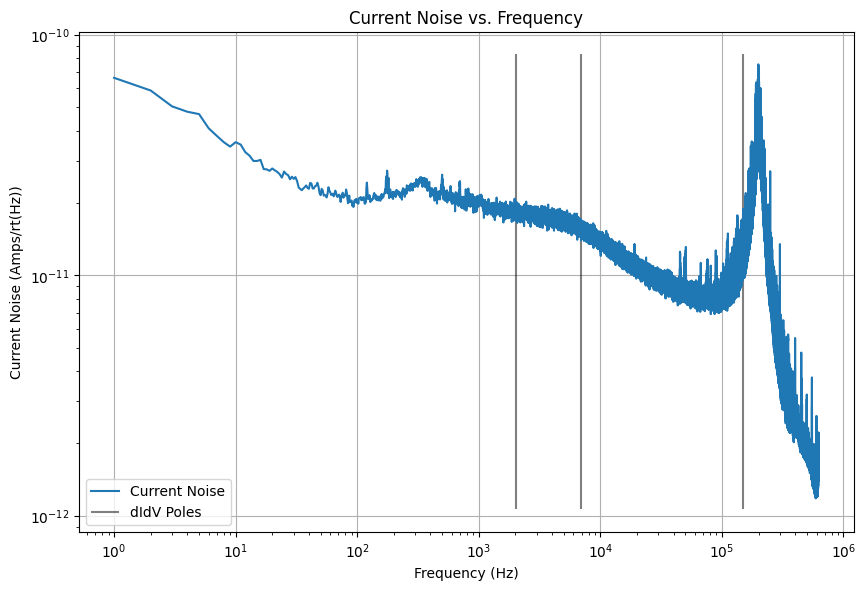

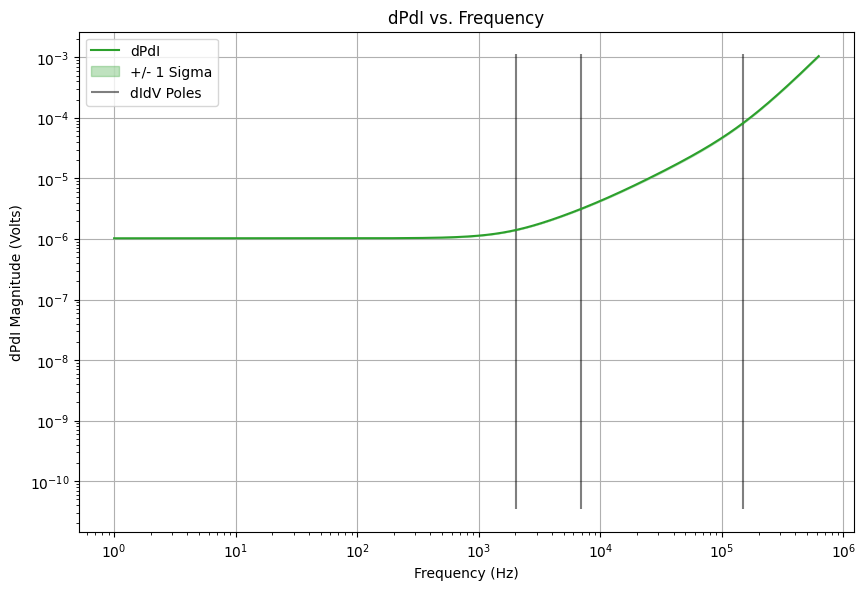

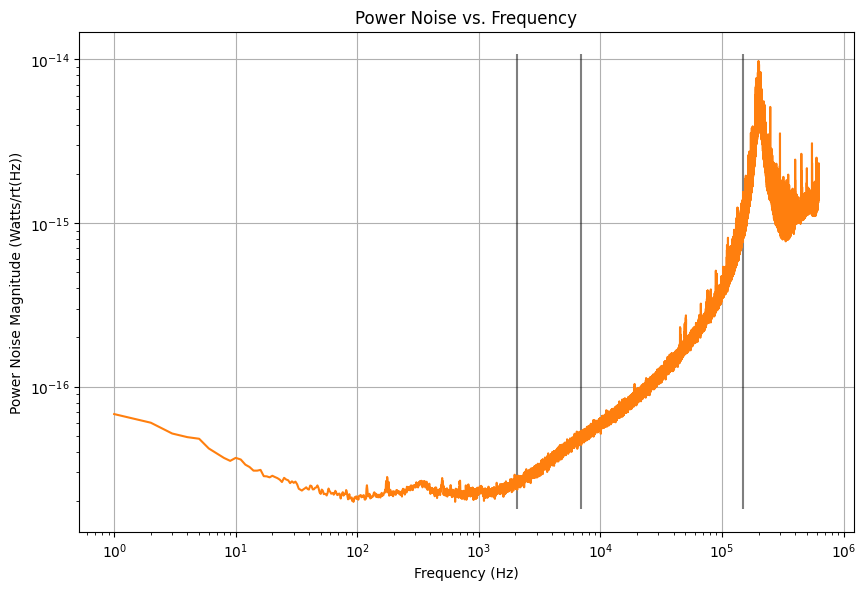

----------------------
Correlated noise (in phonon system):


/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1164: Comp

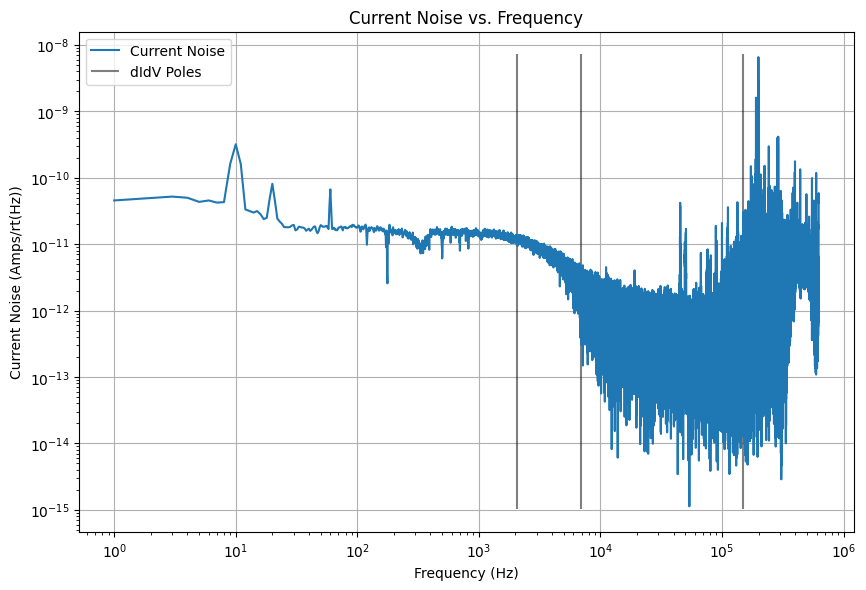

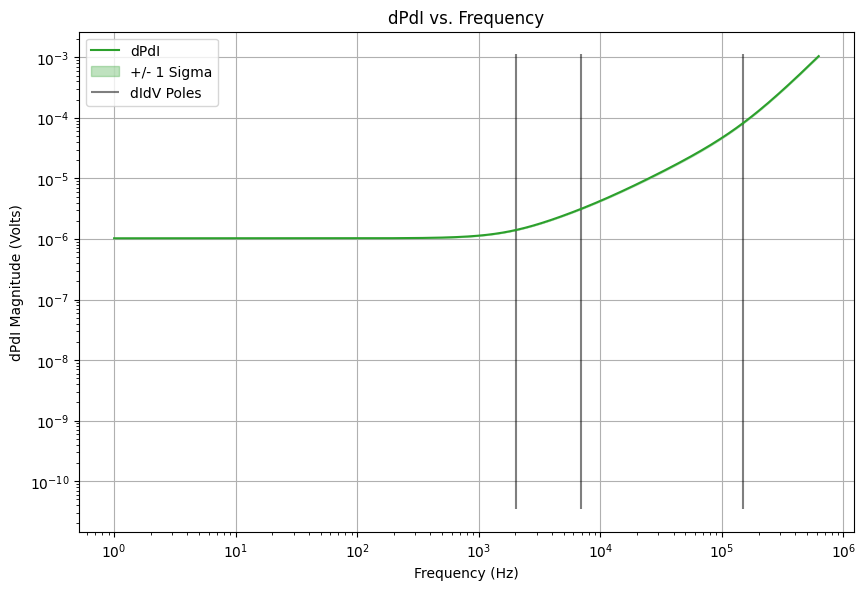

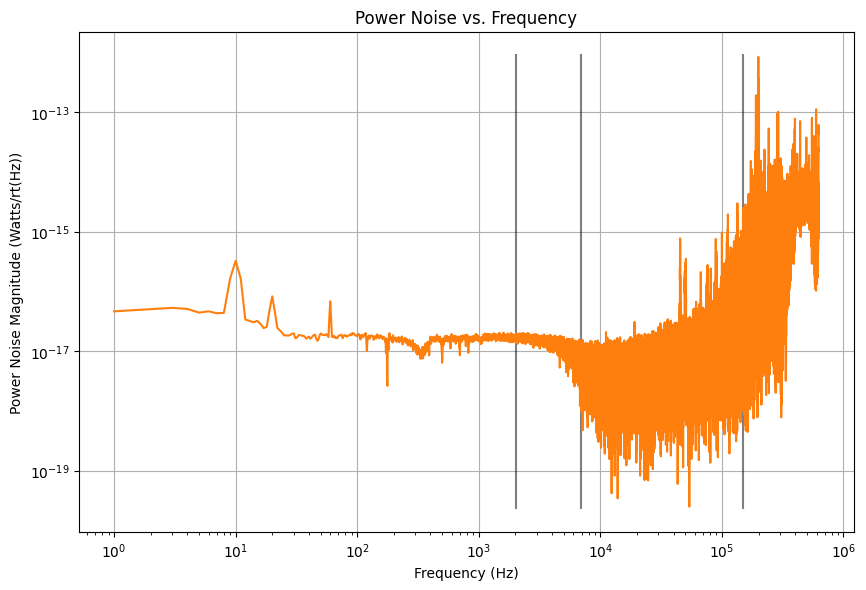

In [50]:
print("Uncorrelated noise (only in TES):")
uncor_noise_power, uncor_noise_power_err, dpdi, dpdi_err = get_power_noise_with_uncertainties(freqs,
                                                                              np.sqrt(uncorrelated_noise_current), 
                                                                              result, 
                                                                              lgcplots=True, lgcdpdireturn=True)

print("----------------------")
print("Correlated noise (in phonon system):")
cor_noise_power, cor_noise_power_err, dpdi, dpdi_err = get_power_noise_with_uncertainties(freqs,
                                                                          np.sqrt(correlated_noise_current), 
                                                                          result, 
                                                                          lgcplots=True, lgcdpdireturn=True)

### Lets plot out the various templates we'e managed to make

In [32]:
# time array, 20 ms long, at a sample fequency fs
t_arr = np.arange(0, 2e-2, 1/fs)

template_didv = get_didv_template(t_arr, 1e-2, result) #this is a template made of the full didv derived didp. Takes into account all the various params


phonon_falltime = 300e-6
template_phonon = get_phonon_template(t_arr, 1e-2, result, phonon_falltime)

/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_templates_didv.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  p_freqs[i] = np.exp(2.0j * np.pi * freqs[i] * start_time)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: Compl

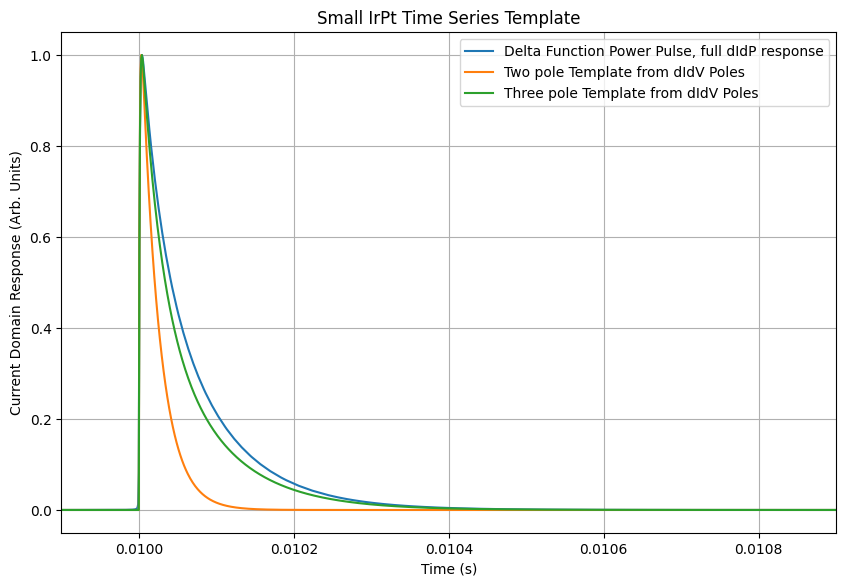

In [35]:
#For short times, we can show that this agrees with a 2 pole template calculated from the dIdV falltimes.
#At longer times, the third pole becomes important

plt.plot(t_arr, template_didv, label = "Delta Function Power Pulse, full dIdP response")
#plt.plot(t_arr, template_didv, label = "Delta Function Power Pulse, full dIdP response")

tau_p = np.abs(result['falltimes'][0])
tau_m = np.abs(result['falltimes'][1])
tau_m2 = np.abs(result['falltimes'][2])

# taus from the two pole fit 
twopole_tau_p = np.abs(result2['falltimes'][0])
twopole_tau_m = np.abs(result2['falltimes'][1])

plt.plot(t_arr, make_template_twopole(t_arr, A = 1.0, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m),
        label = "Two pole Template from dIdV Poles")
plt.plot(t_arr, make_template_threepole(t_arr, A = 1,B=1, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f2=tau_m,tau_f1=tau_m2),
        label = "Three pole Template from dIdV Poles")
#plt.plot(t_arr, template_phonon, label = "Phonon falltime, full dIdP response")

plt.title('Small IrPt Time Series Template')
plt.xlim(9.9e-3, 10.9e-3)
plt.ylabel("Current Domain Response (Arb. Units)")
plt.xlabel("Time (s)")
plt.grid()
#plt.text(0.01041, 0.60, r'A:(1.41 +/- 0.018) [$\mu$A]', fontsize = 16)
#plt.text(0.01041, 0.55, r'B:(-1.80 +/- 0.018) [$\mu$A]', fontsize = 16)
#plt.text(0.01041, 0.55, r'$\tau_{r}$:(1.37) [$\mu$S]', fontsize = 16)
#plt.text(0.01041, 0.50, r'$\tau_{f}$:(25.6) [$\mu$S]', fontsize = 16)
plt.legend()
plt.show()

In [ ]:
ofamp_to_ev = get_energy_normalization(t_arr, template_didv, result, lgc_ev=True)
ofamp_to_joules = get_energy_normalization(t_arr, template_didv, result, lgc_ev=False)

/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1160: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[0] = _ddi0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1161: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[1] = _ddr0_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1162: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[2] = _dddVdI_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1163: ComplexWarning: Casting complex values to real discards the imaginary part
  derived_jacobian[3] = _ddbeta_dPdI_3(didv_result, f)
/home/mwilliams/.local/lib/python3.6/site-packages/qetpy/core/didv/_uncertainties_didv.py:1164: Comp

In [ ]:
ofamp_to_ev

93045886.51786748

In [ ]:
#Let's make some test energy norms with the various templates
twopole_ofamp_to_ev = get_energy_normalization(t_arr,  make_template_twopole(t_arr, A = 1.02, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m), result, lgc_ev=True)
print(twopole_ofamp_to_ev)

92444145.50374645


In [ ]:
#with open('IrPtTESSmall_results.pkl', 'wb') as f:
#    pickle.dump(result, f)


In [ ]:
template_gen = Template(verbose=True)

NameError: name 'Template' is not defined

In [ ]:
template_gen.set_template('IrPtTESSmall', template_didv, sample_rate=1.25e6, 
                          pretrigger_length_msec=0.5)

In [ ]:
template_gen.describe()

In [ ]:
template_gen.plot_template(['IrPtTESSmall'])

In [ ]:
# let's save it in am existing filter file that already has noise PSD
file_name = '/home/mwilliams/detprocess/examples/IrPt_PSDandTwoPole_from3pole_filter.hdf5'
template_gen.save_hdf5(file_name, overwrite=False)

In [ ]:
template_gen.load_hdf5(file_name)
template_gen.describe()

In [ ]:
template_gen.plot_psd(['IrPtTESSmall','IrPtTESBig'], fold=True)

In [ ]:
template_gen.plot_template(['IrPtTESSmall'])

In [ ]:
noise = Noise(verbose=True)

In [ ]:
noise.load_hdf5('./IrPt_PSDandTemplate_filter.hdf5')
noise.describe()

#### Let's read in some real data and compare to the template

In [36]:
import numpy as np
import pandas as pd
from pprint import pprint
import astropy
import vaex as vx
from matplotlib import pyplot as plt
from detanalysis import Analyzer, Semiautocut, ScatterPlotter 
import matplotlib as mpl
import qetpy
import scipy
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import scipy.optimize as opt
from scipy.special import erf
import math

mpl.rcParams['figure.figsize'] = [10, 6.5]
from pytesdaq.io.hdf5 import H5Reader,H5Writer

import warnings
warnings.filterwarnings('ignore')

/usr/lib64/python3.6/importlib/_bootstrap_external.py:426: ImportWarning: Not importing directory /home/mwilliams/.local/lib/python3.6/site-packages/mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


In [37]:
IrPtTESSmall = Analyzer('/sdata1/runs/run20/processed/continuous_I2_D20220918_T165211/TwoChanProc_4sig_newdidv2_feature_I2_D20230624_T110408/',series=None)


In [38]:
highsingles_BigEcut = IrPtTESSmall.df.amp_of1x1_constrained_IrPtTESSmall<2e-8 
#lowsingles_BigEcut = IrPtTESSmall.df.BigTES_Energy>0.5
highsingles_SmallEcut = IrPtTESSmall.df.amp_of1x1_constrained_IrPtTESBig <2.5e-8
lowsingles_SmallEcut = IrPtTESSmall.df.amp_of1x1_constrained_IrPtTESBig >1.5e-8
IrPtTESSmall.register_cut(highsingles_BigEcut,'SmallTES_singles',overwrite=True)
#IrPtTESSmall.register_cut(lowsingles_BigEcut,'SmallTES_singles',mode='and',overwrite=True)
IrPtTESSmall.register_cut(highsingles_SmallEcut,'SmallTES_singles',mode='and',overwrite=True)
IrPtTESSmall.register_cut(lowsingles_SmallEcut,'SmallTES_singles',mode='and',overwrite=True)

In [39]:
traces,info = IrPtTESSmall.get_traces(channels='IrPtTESSmall',raw_path='/sdata1/runs/run20/raw',cut = 'SmallTES_singles',nb_random_samples=100,trace_length_msec = 20)

INFO: Number of events found = 100


In [40]:
lowpassedtraces = []
lowpassedtraces = qetpy.utils.lowpassfilter(traces,cut_off_freq=30000,fs=fs)

In [41]:
timearr = np.linspace(0,20,25000)

In [42]:
timearr = np.linspace(0,20,25000)
pulse_amp = 1e-8 # [A]
tau_f = 23.4e-6 # [s]
tau_r = 1e-6 # [s]
pulse = np.exp(-timearr*1e-3/tau_f)-np.exp(-timearr*1e-3/tau_r)
pulse_shifted = np.roll(pulse, len(timearr)//2)
template = pulse_shifted/pulse_shifted.max()
signal = np.roll(template, 0)*pulse_amp

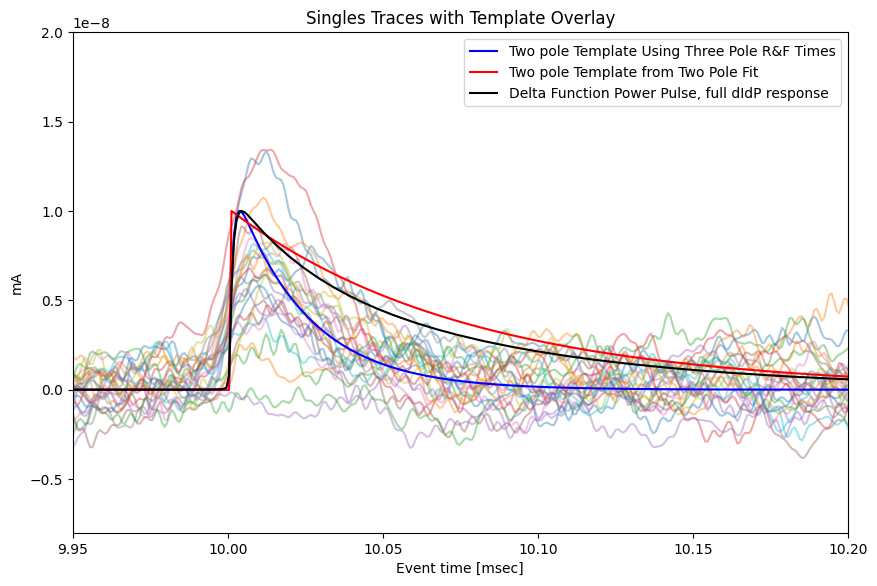

In [49]:
for xx in lowpassedtraces[0:25,0]:
    plt.plot(timearr, xx, alpha=0.4)
#plt.plot(timearr,signal,color='black',label='Template')
plt.plot(timearr, make_template_twopole(t_arr, A = 1, t0 =1e-2, fs = 1.25e6, tau_r=tau_p, tau_f=tau_m)*1e-8,
        label = "Two pole Template Using Three Pole R&F Times",color='blue')
plt.plot(timearr, make_template_twopole(t_arr, A = 1, t0 =1e-2, fs = 1.25e6, tau_r=twopole_tau_p, tau_f=twopole_tau_m)*1e-8,
        label = "Two pole Template from Two Pole Fit",color='red')
plt.xlim(9.95, 10.2)
plt.ylim(-8e-9,2e-8)
plt.plot(timearr, template_didv*1e-8, label = "Delta Function Power Pulse, full dIdP response",color='black')
plt.xlabel('Event time [msec]')
plt.ylabel('mA')
plt.title('Singles Traces with Template Overlay')
plt.legend()
plt.show()